In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pathlib import Path
import re

In [10]:
sns.set(style='darkgrid', palette='coolwarm')

First we read in the data.

In [11]:
DATA_PATH = Path('../data/raw/')
titanic_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')

In [12]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


First I want to see how balanced the target column is, which in this case is the survival column.

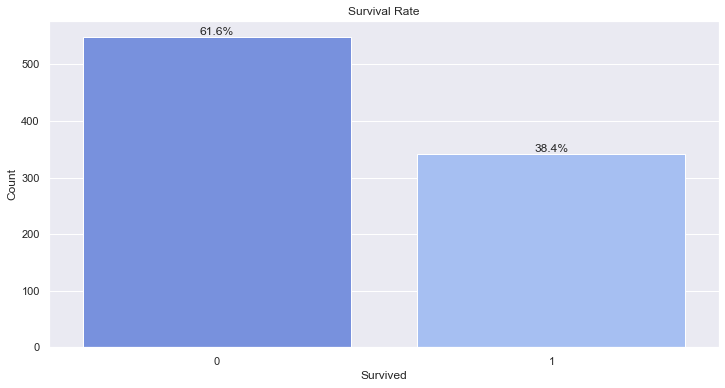

In [14]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x=titanic_df['Survived'])
plt.title('Survival Rate')
plt.ylabel('Count')
ncount = len(titanic_df)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(f'{round(100*(y/ncount), 1)}%', (x.mean(), y), ha='center', va='bottom')

We can see that 61.6% of our sample data did not survive, whereas we have 38.4% surviving. This data is not too unbalanced.

### Missing Data

In [15]:
titanic_df.isnull().sum()[titanic_df.isnull().sum() != 0].sort_values(ascending=False) / len(titanic_df) * 100

Cabin       77.104377
Age         19.865320
Embarked     0.224467
dtype: float64

In our training data, we have two columns that are missing a large amount of their entries. I will try to gage the importance of both columns and also look to fill in missing values with approximations.

In [16]:
test_df.isnull().sum()[test_df.isnull().sum() != 0].sort_values(ascending=False) / len(test_df) * 100

Cabin    78.229665
Age      20.574163
Fare      0.239234
dtype: float64

We should note here that our test file is missing some Fare information and so we should produce a way of filling in this information.

### Age

In [17]:
titanic_df["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Text(0.5, 1.0, 'Age Distribution')

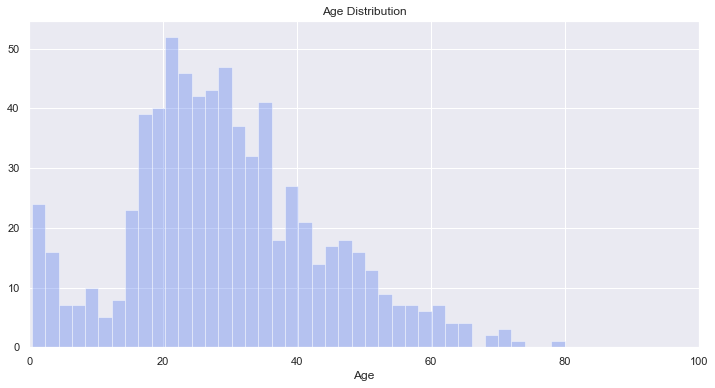

In [18]:
plt.figure(figsize=(12,6))
sns.distplot(titanic_df['Age'].dropna(), bins=40, kde=False)
plt.xlim((0,100))
plt.title('Age Distribution')

Most of the people in the data set are within the ages 20 and 38 but there are a fair amount of children also. It seems like a good idea to either create a new column to signify being a child or to include a child category in the sex column. Perhaps it would be a good idea to create an ordinal data column that uses age ranges instead of precise ages.

Lets look at how many missing values we have in the age column.

In [19]:
print(f"Age column missing {round(100*titanic_df['Age'].isnull().sum()/len(titanic_df), 1)}%")

Age column missing 19.9%


Age could be an important predictor for survival so we will need to decide how best to fill any missing values.

### Sex

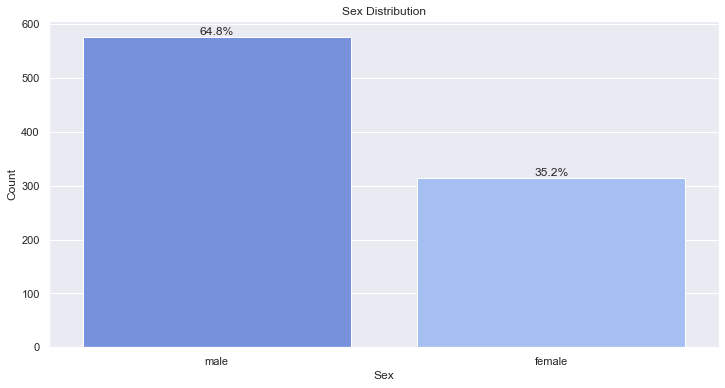

In [20]:
plt.figure(figsize=(12,6))
ax = sns.countplot(titanic_df["Sex"])
plt.title('Sex Distribution')
plt.ylabel('Count')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{round(100*(y/ncount), 1)}%', (x.mean(), y), ha='center', va='bottom')

There is almost two men for every female in the dataset.

Text(0, 0.5, 'Count')

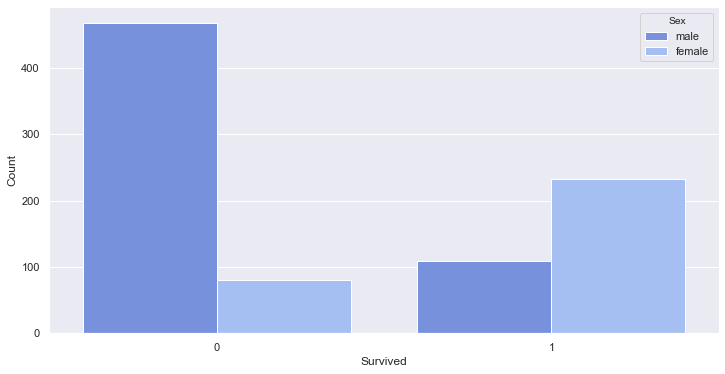

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(x=titanic_df["Survived"], hue=titanic_df["Sex"])
plt.ylabel('Count')

In [22]:
survival_by_sex = titanic_df.pivot_table(values='PassengerId', index='Sex', columns='Survived', aggfunc='count')

for sex in ['female', 'male']:
    survival_rate = 100*survival_by_sex[1].loc[sex]/(survival_by_sex[0].loc[sex] + survival_by_sex[1].loc[sex])
    print(f'{sex.capitalize()} survival rate: {round(survival_rate, 1)}%')
    
survival_by_sex

Female survival rate: 74.2%
Male survival rate: 18.9%


Survived,0,1
Sex,,
female,81,233
male,468,109


Although there is a much larger amount of men in the data set, a disproportionate number of women survive compared to the men, 74.2% compared to 18.9%. This seems to identify that being female had a positive correlation with likelihood of survival.

### Pclass

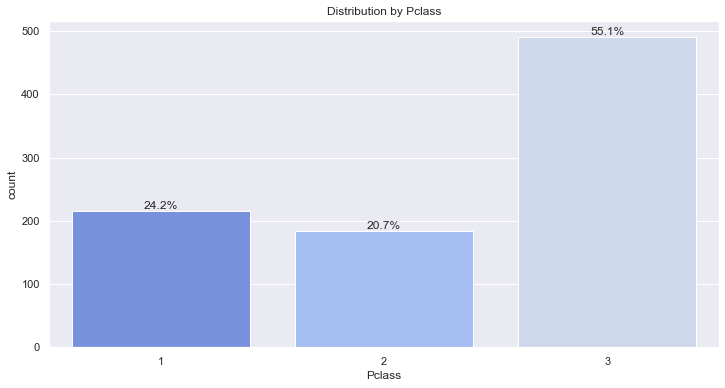

In [23]:
plt.figure(figsize=(12,6))
ax = sns.countplot(titanic_df["Pclass"])
plt.title('Distribution by Pclass')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{round(100*y/ncount, 1)}%', (x.mean(), y), ha='center', va='bottom')

We can see that most of the passengers on the ship were in 3rd class. There is more passengers in first class than I thought there would be, I thought the number of people in each class would decrease with the passenger class.

Text(0, 0.5, 'Count')

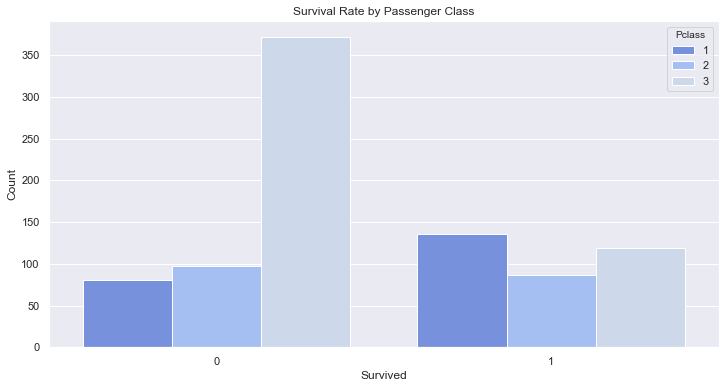

In [24]:
plt.figure(figsize=(12,6))
sns.countplot(x=titanic_df["Survived"], hue=titanic_df["Pclass"])
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Count')

We can see that the lower passenger classes had a higher survival rate than the 3rd class passengers. This could be another good predictor for survival. Lets inspect how different the survival rates were.

In [25]:
survival_by_pclass = titanic_df.pivot_table(index='Pclass', columns='Survived', values='PassengerId', aggfunc='count')

for pclass in [1,2,3]:
    survival_rate = (
        100*survival_by_pclass[1].loc[pclass]/(survival_by_pclass[1].loc[pclass]+survival_by_pclass[0].loc[pclass])
    )
    print(f'Passenger class {pclass} survival rate: {round(survival_rate, 1)}%')

survival_by_pclass

Passenger class 1 survival rate: 63.0%
Passenger class 2 survival rate: 47.3%
Passenger class 3 survival rate: 24.2%


Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


We can see here the survival rate increased when the passenger class decreased. This is not suprising as people in a higher class would have been put on life boats faster.

### Fare

In [26]:
titanic_df["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

(0, 537.94566)

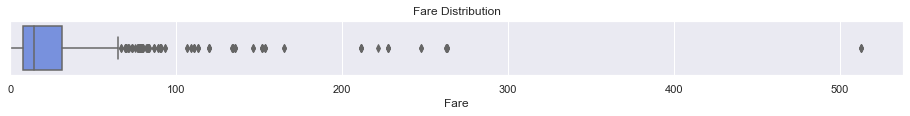

In [27]:
plt.figure(figsize=(16,1))
sns.boxplot(titanic_df["Fare"])
plt.title('Fare Distribution')
plt.xlim(left=0)

The fares column is positively skewed with a large number of outliers. This is likely due to the higher proportion of 3rd class tickets being sold and the passengers liklely paid much less for these tickets. There is a much smaller proportion of 1st class tickets, which account for the outliers. Let's check this hypothesis is correct.

In [28]:
titanic_df.groupby('Pclass').describe()['Fare']

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


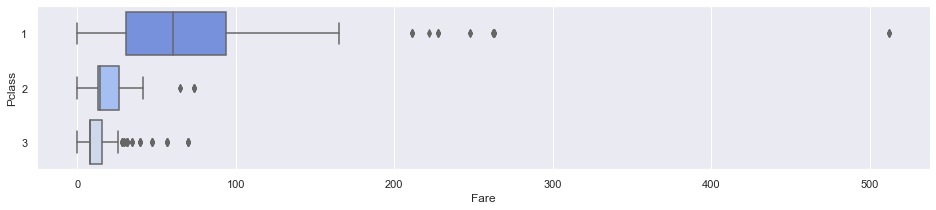

In [29]:
plt.figure(figsize=(16,3))
sns.boxplot(x=titanic_df['Fare'], y=titanic_df['Pclass'].astype('category'))

As expected people in better passenger classes paid more for the fare than passengers in worse classes. What is surprising is that many passengers paid more for their 3rd class tickets than the mean fare for 2nd class. Also there are people in every class that didn't pay a fare at all, could these be staff members?

In [30]:
titanic_df[titanic_df['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


It is not clear why any of these passengers did not have to pay a fare. Though some tickets say 'LINE' instead of a number, could these signify staff?

### Embarked

In [31]:
titanic_df["Embarked"].describe(include='object')

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

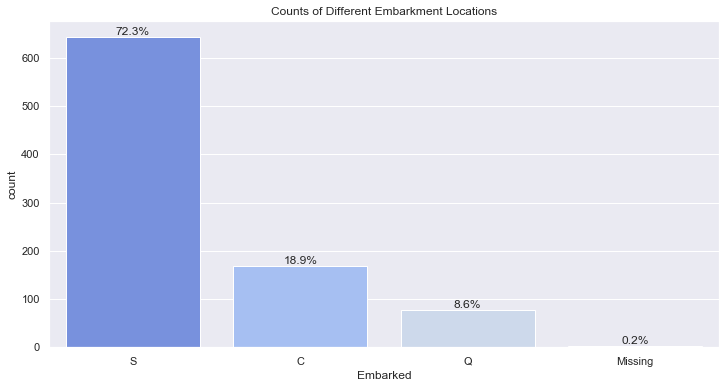

In [32]:
plt.figure(figsize=(12,6))
ax = sns.countplot(titanic_df["Embarked"].fillna('Missing'))
plt.title('Counts of Different Embarkment Locations')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{round(100*y/ncount, 1)}%', (x.mean(), y), ha='center', va='bottom')

Most people boarded at Southampton. It makes sense to replce the missing two values with 'S' as the most common entry when I clean the data.

Now let's look if the location that the passengers embarked has any predictive value for survival.

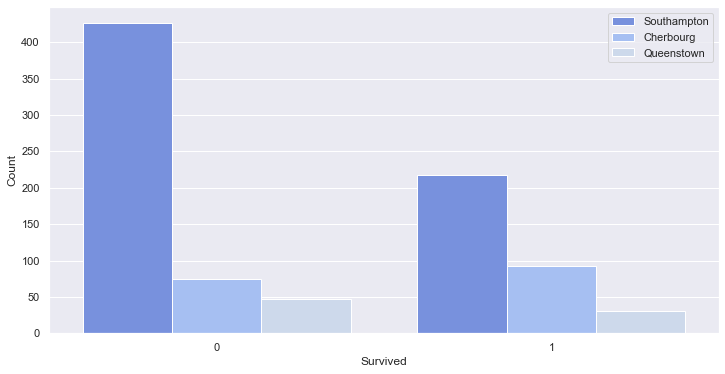

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(x=titanic_df["Survived"], hue=titanic_df["Embarked"])
plt.ylabel('Count')
plt.legend(['Southampton', 'Cherbourg', 'Queenstown'], loc=1)

In [34]:
survival_by_eloc = titanic_df.pivot_table(values='PassengerId', index='Embarked', columns='Survived', aggfunc='count')

for loc, name in [('S','Southampton'), ('C','Cherbourg'), ('Q','Queenstown')]:
    survival_rate = 100*survival_by_eloc[1].loc[loc]/(survival_by_eloc[0].loc[loc] + survival_by_eloc[1].loc[loc])
    print(f'{name} survival rate: {round(survival_rate, 1)}%')
    
survival_by_sex

Southampton survival rate: 33.7%
Cherbourg survival rate: 55.4%
Queenstown survival rate: 39.0%


Survived,0,1
Sex,,
female,81,233
male,468,109


It seems there embarkment has at least some predictive purpose. Perhaps more people from 1st class got on in Cherbourg?

### Name

In [35]:
titanic_df['Name'].describe(include='object')

count                            891
unique                           891
top       Collander, Mr. Erik Gustaf
freq                               1
Name: Name, dtype: object

Every passenger has a unique name, I don't think I can use this column for my model as it doesn't offer any obvious links to the survival of the passenger. Perhaps I could extract the title from the name, we might find, for example, if there were any titles 'Dr' they might be busy attending to people to get off in time but for now I won't use this column. Or perhaps we could identify married couples and maybe their survival is connected.

### SibSp

In [36]:
titanic_df['SibSp'].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

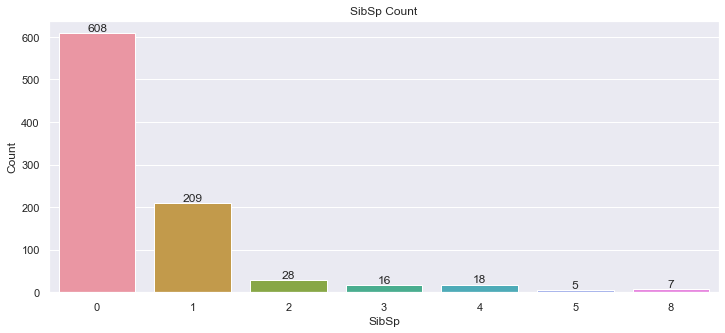

In [37]:
plt.figure(figsize=(12,5))
ax = sns.countplot(titanic_df['SibSp'].astype('category'))
plt.title('SibSp Count')
plt.ylabel('Count')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

This is slightly confusing to me as you'd expect if there was a passenger on the ship with 8 siblings, then you'd expect another 8 on the ship who also have 8 siblings (9 total).

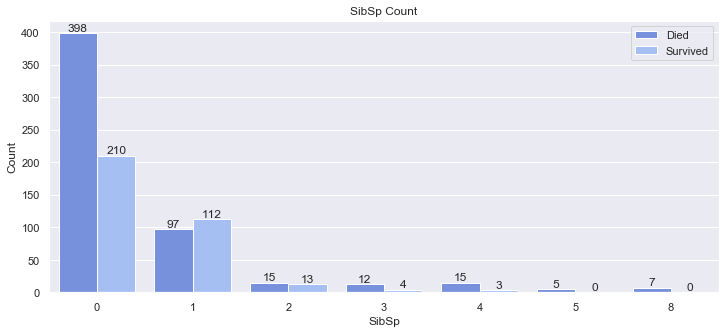

In [38]:
plt.figure(figsize=(12,5))
ax = sns.countplot(titanic_df['SibSp'].astype('category'), hue=titanic_df['Survived'])
plt.title('SibSp Count')
plt.ylabel('Count')
plt.legend(['Died', 'Survived'], loc=1)

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = np.nan_to_num(p.get_bbox().get_points()[1,1])
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

It seems that having a SibSp value of one or two could be beneficial to survival. I predict this could be because families would try to stick together/save one another and so having a higher SibSp could put someone in more danger. Though I think it is more likely that the passengers with one or two SibSp could be children and so have a higher likelihood to survive as children were looked after better.

It could be interesting to try to separate the siblings and spouse information. We could use the age of the passenger to predict if a one in the SibSp column meant a spouse or a sibling. This may be tricky though because the legal age to marry in 1912 was much lower. Girls could marry as young as 12 up until 1929 when the legal age was increased to 16.

### Parch

In [39]:
titanic_df['Parch'].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

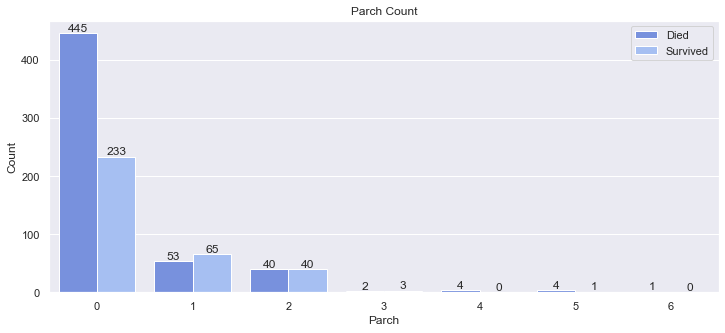

In [40]:
plt.figure(figsize=(12,5))
ax = sns.countplot(titanic_df['Parch'].astype('category'), hue=titanic_df['Survived'])
plt.title('Parch Count')
plt.ylabel('Count')
plt.legend(['Died', 'Survived'], loc=1)

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = np.nan_to_num(p.get_bbox().get_points()[1,1])
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

The majority of passengers seem to have no parents or children on the ship. Those with parents or children seem to have a higher probability of survival, probably because a large proportion of these will be children and if they aren't children they would have a higher probability to be let on to the lifeboats with their child.

We could combine Parch and SibSp columns to indicate the total number of relatives on the ship.

### Ticket

In [41]:
titanic_df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [42]:
titanic_df['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

The ticket information here looks fairly confusing and I reckon will be fairly useless. I will ignore this for now but may come back for further inspection if my model is underperforming.

From brief inspection, as there are only 681 unique ticket codes could the non-unique codes be families and people travelling together? This could perhaps be useful in identifying families/married couples.

### Cabin

For the cabin, I am assuming that if the entry is empty the passenger did not have a private cabin.

In [43]:
titanic_df['Cabin'].describe()

count             204
unique            147
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

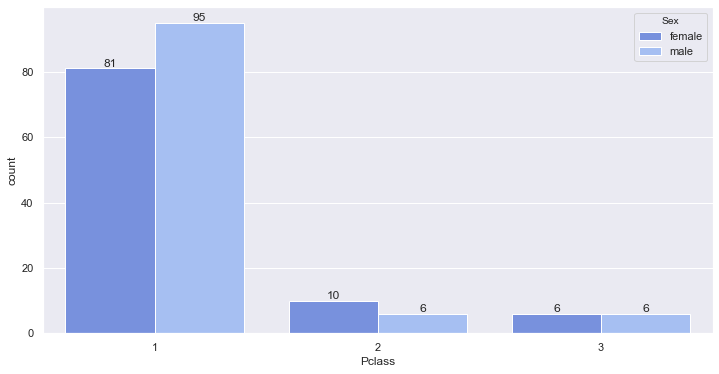

In [45]:
passengers_with_cabins = titanic_df[pd.notnull(titanic_df['Cabin'])]
plt.figure(figsize=(12,6))
ax = sns.countplot(passengers_with_cabins['Pclass'].astype('category'), hue=passengers_with_cabins['Sex'])


for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

It would seem the majority of passengers with cabins were from 1st class, with only a handful of passengers with a cabin from classes 2 and 3. The cabins could could have some significance as to where on the ship passengers were, which could indicate how likely they were to get to a lifeboat and survive. Let's investigate the format of the cabin codes.

In [46]:
titanic_df['Cabin'].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
C22 C26        3
F2             3
              ..
A10            1
B79            1
E77            1
D11            1
D37            1
Name: Cabin, Length: 147, dtype: int64

It would appear that the cabin codes start with a letter, this could help us identify the location on the ship where these passengers were. We can then see if being in a cabin with a certain starting letter corresponded to a higher or lower survival rate.

In [47]:
titanic_df['Cabin'] = titanic_df['Cabin'].apply(
    lambda x: re.compile('[a-zA-Z]+').search(x)[0] if pd.notnull(x) else np.nan
)

In [48]:
titanic_df['Cabin'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

Now that we have our data in a more usable format we can investigate the relationship with cabin code and survival rate.

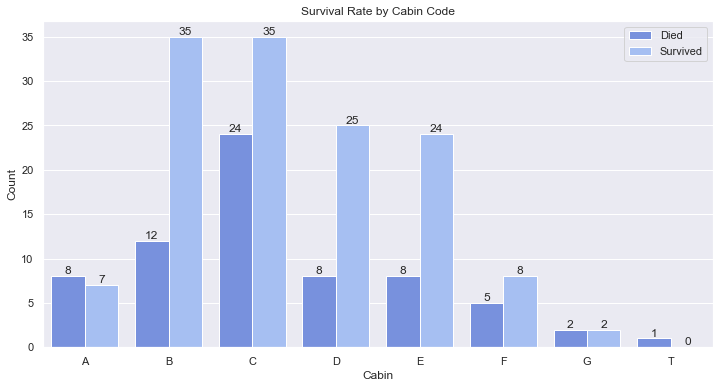

In [49]:
plt.figure(figsize=(12,6))
passengers_with_cabins = titanic_df[titanic_df['Cabin'].notnull()]
ax = sns.countplot(
    passengers_with_cabins['Cabin'],
    hue=passengers_with_cabins['Survived'],
    order=sorted(passengers_with_cabins['Cabin'].unique())
)
plt.legend(['Died', 'Survived'], loc=1)
plt.title('Survival Rate by Cabin Code')
plt.ylabel('Count')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = np.nan_to_num(p.get_bbox().get_points()[1,1])
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

In [50]:
pass_by_cabin_scount = passengers_with_cabins.pivot_table(
    values='PassengerId',
    index='Cabin',
    columns='Survived',
    aggfunc='count'
).fillna(0)
for cabin in pass_by_cabin_scount.index:
    survived = pass_by_cabin_scount[1][cabin]
    died = pass_by_cabin_scount[0][cabin]
    print(f'Cabin {cabin} survival rate: {round(100*survived/(survived+died), 1)}%')

Cabin A survival rate: 46.7%
Cabin B survival rate: 74.5%
Cabin C survival rate: 59.3%
Cabin D survival rate: 75.8%
Cabin E survival rate: 75.0%
Cabin F survival rate: 61.5%
Cabin G survival rate: 50.0%
Cabin T survival rate: 0.0%


It would appear that there is some discrepency in survival rate between cabin numbers, though as it's such a small sample size this could be due to chance. Never the less, it could be useful to include in my model.

From researching the layout of the ship I have found that the letter refers to the deck the cabin is positioned. I have also found that, as far as I can tell, there was no deck T so I think this could be an error in the data entry. From this I think I will encode the upper deck starting as 1 and then increment the number for lower decks, any missing data (or data that isn't in the deck list) I will encode as 0. 

In [51]:
decks = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'U': 8, 'T': 8}
titanic_df['Cabin'] = titanic_df['Cabin'].fillna('U')
titanic_df['Deck'] = titanic_df['Cabin'].apply(lambda x: re.compile('[a-zA-Z]+').search(x).group())
titanic_df['Deck'].map(decks).value_counts()

8    688
3     59
2     47
4     33
5     32
1     15
6     13
7      4
Name: Deck, dtype: int64

### Correlations

Lets create dummy variables for some of the columns and look at the correlations between variables.

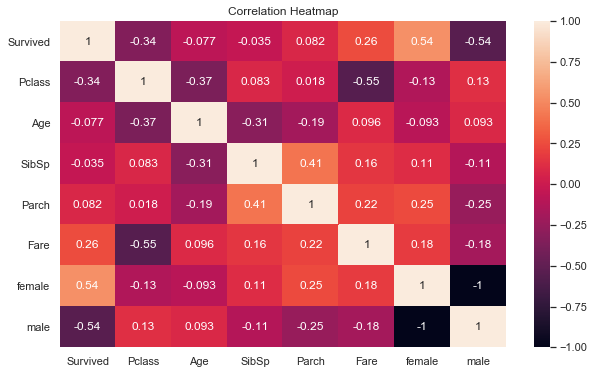

In [53]:
corr_df = titanic_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
corr_df = pd.concat([corr_df, pd.get_dummies(titanic_df['Sex'])], axis=1)
corr_df.drop('Sex', axis=1, inplace=True)

plt.figure(figsize=(10,6))
plt.title('Correlation Heatmap')
sns.heatmap(corr_df.corr(), annot=True)

Ignoring the obvious correlations (male strongly negatively correlated with female, etc.) there are some interesting correlations. Survival being negatively correlated with Pclass and positively correlated with Fare coincides with our findings above. Also having a positive correlation with female confirms this will be a good predictor. 

## Conclusion

This concludes my exploratory data analysis. Key points:

- I will drop the Ticket column for my model as there is too much variance in the data and I don't believe I will be able to engineer any features from the column. I will also drop the PassengerId column as it is another non-informative column.
- The columns with missing data that will need to be filled/dropped are Age, Fare, Embarked, Cabin.
- I believe I will be able to fill in missing age values by imputing the data using another machine learning model.
- I will engineer a child indicator so that it is more easy for the model to assess age.
- I will engineer a cabin category to indicate which (if any) cabin the passenger was in.